[*********************100%***********************]  1 of 1 completed


Epoch 2/200, Train Loss: 0.007064, Valid Loss: 0.014620
Epoch 4/200, Train Loss: 0.001070, Valid Loss: 0.001079
Epoch 6/200, Train Loss: 0.000825, Valid Loss: 0.000685
Epoch 8/200, Train Loss: 0.000684, Valid Loss: 0.000491
Epoch 10/200, Train Loss: 0.000678, Valid Loss: 0.000357
Epoch 12/200, Train Loss: 0.000704, Valid Loss: 0.000343
Epoch 14/200, Train Loss: 0.000571, Valid Loss: 0.000268
Epoch 16/200, Train Loss: 0.000578, Valid Loss: 0.000261
Epoch 18/200, Train Loss: 0.000586, Valid Loss: 0.000238
Epoch 20/200, Train Loss: 0.000567, Valid Loss: 0.000231
Epoch 22/200, Train Loss: 0.000600, Valid Loss: 0.000232
Epoch 24/200, Train Loss: 0.000532, Valid Loss: 0.000242
Epoch 26/200, Train Loss: 0.000533, Valid Loss: 0.000304
Epoch 28/200, Train Loss: 0.000493, Valid Loss: 0.000247
Epoch 30/200, Train Loss: 0.000469, Valid Loss: 0.000277
Epoch 32/200, Train Loss: 0.000546, Valid Loss: 0.000259
Epoch 34/200, Train Loss: 0.000469, Valid Loss: 0.000221
Epoch 36/200, Train Loss: 0.000454,

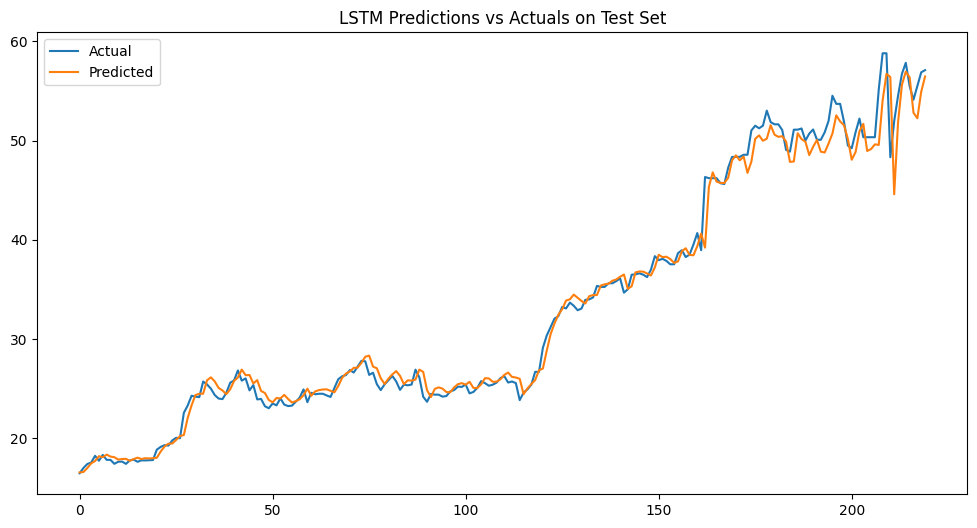

<ipython-input-1-1d767a89f4b9>:188: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('lstm_model.pth'))


LSTMModel(
  (lstm): LSTM(4, 50, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [1]:
# Import necessary libraries
import pandas as pd  # Data manipulation and analysis
import numpy as np  # Numerical operations
import yfinance as yf  # Fetch stock market data
import torch  # PyTorch for deep learning
import torch.nn as nn  # Neural network module
import torch.optim as optim  # Optimization algorithms
from sklearn.preprocessing import MinMaxScaler  # Normalize data for better training performance
import matplotlib.pyplot as plt  # Data visualization
from torch.utils.data import DataLoader, TensorDataset  # Efficient data handling for training

# Step 1: Load and Preprocess Data
# Define date range for stock data retrieval
end_date = pd.Timestamp.today()
start_date = end_date - pd.DateOffset(years=5)  # Last 5 years

# Download historical stock prices for Siemens Energy (ENR.DE) from Yahoo Finance
df = yf.download('ENR.DE', start=start_date, end=end_date)

# Keep only the 'Close' price column, as it's the target for prediction
df = df[['Close']]
df = df.sort_index()  # Ensure data is sorted by date

# Step 2: Create Lag and Rolling Features
df['lag_5'] = df['Close'].shift(5)  # Create a lag feature (price 5 days ago)
df['rolling_mean_10'] = df['Close'].rolling(window=10).mean()  # 10-day moving average
df['rolling_sd_10'] = df['Close'].rolling(window=10).std()  # 10-day rolling standard deviation

df.dropna(inplace=True)  # Remove rows with NaN values (from shifting and rolling)

# Step 3: Normalize the Data
scaler = MinMaxScaler()  # Scale data to range [0,1] to improve model performance
data_scaled = scaler.fit_transform(df)  # Apply normalization

# Step 4: Prepare Data for LTSM Input
def create_sequences_multivariate(data, n_timesteps, target_column_index):
    """
    Create sequences of past `n_timesteps` observations for input (X)
    and the next day's target value (y).
    """
    X = []
    y = []
    for i in range(len(data) - n_timesteps):
        seq_x = data[i:i + n_timesteps]  # Last `n_timesteps` days
        seq_y = data[i + n_timesteps, target_column_index]  # Next day's price
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_timesteps = 5  # How many past days to use for prediction
n_features = data_scaled.shape[1]  # Number of features (columns)
target_column_index = 0  # 'Close' is the target column

# Generate sequences for training/testing
X, y = create_sequences_multivariate(data_scaled, n_timesteps, target_column_index)

# Step 5: Split Data into Training and Testing Sets
train_size = int(len(X) * 0.8)  # Use 80% of data for training
train_X, test_X = X[:train_size], X[train_size:]
train_y, test_y = y[:train_size], y[train_size:]

# Further split training data into train and validation sets (80% train, 20% validation)
train_size_final = int(len(train_X) * 0.8)
train_X_final, valid_X = train_X[:train_size_final], train_X[train_size_final:]
train_y_final, valid_y = train_y[:train_size_final], train_y[train_size_final:]

# Convert data to PyTorch tensors for deep learning model
train_X_tensor = torch.tensor(train_X_final, dtype=torch.float32)
train_y_tensor = torch.tensor(train_y_final, dtype=torch.float32)
valid_X_tensor = torch.tensor(valid_X, dtype=torch.float32)
valid_y_tensor = torch.tensor(valid_y, dtype=torch.float32)
test_X_tensor = torch.tensor(test_X, dtype=torch.float32)
test_y_tensor = torch.tensor(test_y, dtype=torch.float32)

# Create DataLoader for batching (helps with efficient training)
train_data = TensorDataset(train_X_tensor, train_y_tensor)
valid_data = TensorDataset(valid_X_tensor, valid_y_tensor)
test_data = TensorDataset(test_X_tensor, test_y_tensor)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)  # Shuffle training data for better learning
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)  # No shuffle for validation
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)  # No shuffle for test

# Step 6: Build the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=50, num_layers=2, output_size=1, dropout=0.2):
        """
        Define an LSTM model for time series prediction.
        - input_size: Number of features (columns in the dataset)
        - hidden_size: Number of units in LSTM layers
        - num_layers: Number of stacked LSTM layers
        - output_size: Single output (predicted closing price)
        - dropout: Regularization to prevent overfitting
        """
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)  # Fully connected output layer

    def forward(self, x):
        """
        Forward pass through the LSTM model.
        """
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # Initialize hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # Initialize cell state
        out, (hn, cn) = self.lstm(x, (h0, c0))  # Pass data through LSTM layers
        out = out[:, -1, :]  # Take output from the last time step
        out = self.fc(out)  # Apply final linear layer
        return out

# Instantiate the LSTM model
model = LSTMModel(input_size=n_features, hidden_size=50, num_layers=2, output_size=1, dropout=0.2)

# Define loss function (MSE for regression) and optimizer (Adam for adaptive learning)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 7: Train the Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available
model.to(device)  # Move model to device

num_epochs = 200  # Number of training epochs
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs.squeeze(), targets)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation step
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for inputs, targets in valid_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            valid_loss += loss.item() * inputs.size(0)

    valid_loss /= len(valid_loader.dataset)
    valid_losses.append(valid_loss)

    if (epoch + 1) % 2 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.6f}, Valid Loss: {valid_loss:.6f}')

# Step 8: Evaluate the Model
model.eval()
with torch.no_grad():
    test_preds = model(test_X_tensor.to(device)).cpu().numpy()
    test_actuals = test_y_tensor.numpy()

# Function to denormalize predictions back to actual price values
def denormalize(scaled_data, scaler, index):
    data = np.zeros((len(scaled_data), scaler.n_features_in_))
    data[:, index] = scaled_data[:, 0]
    return scaler.inverse_transform(data)[:, index]

test_preds_denorm = denormalize(test_preds, scaler, target_column_index)
test_actuals_denorm = denormalize(test_actuals.reshape(-1, 1), scaler, target_column_index)

# Visualize predictions vs actuals
plt.figure(figsize=(12, 6))
plt.plot(test_actuals_denorm, label='Actual')
plt.plot(test_preds_denorm, label='Predicted')
plt.title('LSTM Predictions vs Actuals on Test Set')
plt.legend()
plt.show()

# Step 9: Save and Load the Model
torch.save(model.state_dict(), 'lstm_model.pth')

# Reload model (optional)
loaded_model = LSTMModel(input_size=n_features, hidden_size=50, num_layers=2, output_size=1)
loaded_model.load_state_dict(torch.load('lstm_model.pth'))
loaded_model.to(device)
loaded_model.eval()
